In [3]:
from graphsage.utils import load_data
import matplotlib.pyplot as plt
import numpy as np

train_data = load_data("./example_data/toy-ppi", load_walks=True)


Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..


Note: I tried for a couple of days to get this toy graph imported into igraph, so that i could export it and then work with it in R. But unfortunately since this codebase is in python2.7, there was no way to get it to play nice with igraph, even using advice I found in online forums. So I reluctantly had to use networkx, which i am not as familiar with. 

In [6]:
G = train_data[0]
features = train_data[1]
id_map = train_data[2]
features.shape
len(id_map)


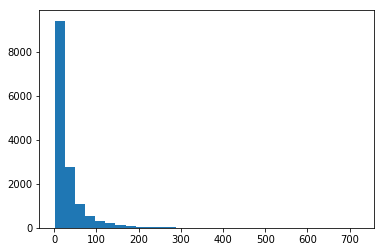

I generated the file of node embeddings below by calling from within the docker container (after some debugging)
`python -m graphsage.unsupervised_train --save_embeddings --base_log_dir=~/log_dir --train_prefix ./example_data/toy-ppi --model n2v --max_total_steps 1000 --validate_iter 10`
and then exporting it from the docker container to my local

In [18]:
node_embeddings = np.genfromtxt('n2v_data2/val.csv', delimiter = ",")
len(node_embeddings)

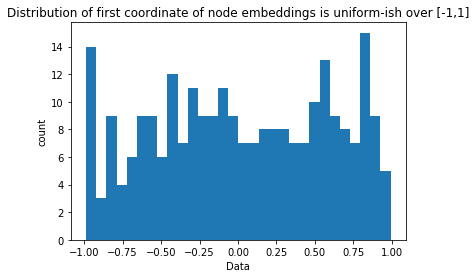

In [51]:
%matplotlib inline

np.random.seed(42)

plt.hist(node_embeddings[1,:], bins=30)  # density=False would make counts
plt.ylabel('count')
plt.xlabel('Data');
plt.title("Distribution of first coordinate of node embeddings is uniform-ish over [-1,1]")

Now lets take a look at a selection of node embeddings that are similar to each other, and see if we can find similarities in their features, or the topology of their neighborhoods. 

119.802838674
14120


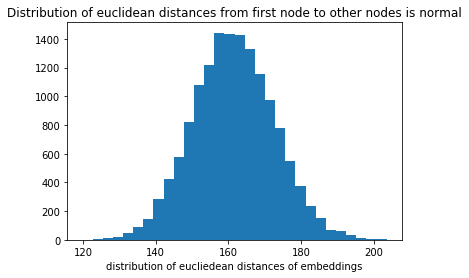

In [53]:
test_node = node_embeddings[0]
distances = []
for i in range(len(node_embeddings)-1):
    other_node = node_embeddings[i+1]
    distances.append(np.sum((other_node-test_node)**2))

    
plt.hist(distances, bins=30)  # density=False would make counts
plt.xlabel('distribution of eucliedean distances of embeddings');
plt.title("Distribution of euclidean distances from first node to other nodes is normal")
min_distance = np.min(distances)
min_distance_node = np.where(distances == min_distance)[0][0]
print(min_distance)
print(min_distance_node)


num neighbors for node 1: 19
num neighbors for NN of node 1: 10
mean degree: 30.9631989156
max degree: 722
min degree: 1


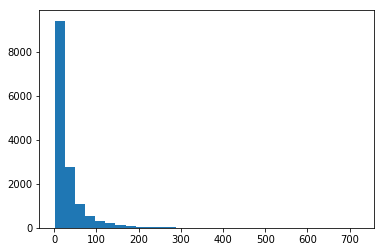

In [131]:
#now we have two nodes that are nearest neighbors to each other in latent space.
#what can we say about them?
count = 0
for n in G.neighbors(0):
    count=count+1
print("num neighbors for node 1: " + str(count))
count2=0
for n in G.neighbors(min_distance_node):
    count2=count2+1
print("num neighbors for NN of node 1: " + str(count2))
#this is the degree distribution, as a reference:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    print("mean degree: " + str(np.mean(degrees)))
    print("max degree: " + str(np.max(degrees)))
    print("min degree: " + str(np.min(degrees)))
    plt.hist(degrees,bins=30)
    plt.show()
plot_degree_dist(G)

So, it turns out that these two nodes have very similar degrees: 10 and 19. At least they are well within 10 of each other on a graph whose degree distribution goes from 0 to almost 1000. 

In [68]:
from networkx import pagerank
pr = pagerank(G)
pr_array = [pr[n] for n in range(len(pr))]
node_1_pr = pr[0]
node_1_nn_pr = pr[min_distance_node]
pr_array = [pr[n] for n in range(len(pr))]
plt.hist(pr_array, bins=100)  # density=False would make counts
plt.xlabel('distribution of pagerank values');
plt.xlim([0, .0005])
plt.axvline(node_1_pr, color='k', linestyle='dashed', linewidth=1)
plt.axvline(node_1_nn_pr, color='k', linestyle='dashed', linewidth=1)

print("node 1 page rank score: " + str(node_1_pr))
print("node 1 NN page rank score: " + str(node_1_nn_pr))

the above histogram shows the distribution of pagerank scores for all ~15000 nodes in the network, with a cutoff for very large values so  it can be read more easily. We can see that the pagerank scores are also very similar. This suggest that these two scores are related. Of course, they are both based on random walks, but the deepwalk algorithm is much more complex because the kernel is path-dependent.

While these two randomly selected nearest neighbor nodes in latent space obviously have similar topological properties, one might wonder why they aren't more similar. This is because the node embedding is based not only on the graph's structure, but also a 50-dimensional feature vector that is associated with each node. 

Finally, we might ask how far apart these nodes are from one another.

In [96]:
from networkx import shortest_path_length
shortest_path_length(G, min_distance_node,0)

NetworkXNoPath: No path between 14120 and 0.

Interestingly, it appears that not only are these two points not neighbors -- they aren't even connected! 
Is that even possible? Let's look at the number of connected components in our graph:

In [99]:
from networkx import connected_components,number_connected_components
cc = number_connected_components(G)
print("cc: " + str(cc))
#it looks like this graph is highly disconnected. 
#maybe they both have self loops?
self_loops = G.nodes_with_selfloops()
print("first node has self loop? " + str(0 in self_loops))
print("nn of first node has self loop? " + str(min_distance_node in self_loops))
#nope...
#lets look deeper at the connected components in which our two points live
S = [G.subgraph(c).copy() for c in connected_components(G)]


cc: 68


In [126]:
cc_1 = 0
cc_nn = 0
for i in range(len(S)):
    thisGraph = S[i]
    nodes=thisGraph.nodes()
    if 0 in nodes: 
        cc_1=i
    if min_distance_node in nodes:
        cc_nn=i

print("connected component of first point: " + str(cc_1))
print("connected component of nearest neighbor to first point in latent space: " + str(cc_nn))

print("size of first connected component: " + str(len(S[cc_1].nodes())))
print("size of nn connected component: " + str(len(S[cc_nn].nodes())))


connected component of first point: 0
connected component of nearest neighbor to first point in latent space: 49
size of first connected component: 3195
size of nn connected component: 3194


As we can see, although these two nodes live in different connected components, those components have nearly the exact same size. This could mean that their latent representations are similar. Let's look deeper into those components. What are their average degrees?

mean degree: 31.3283255086
max degree: 541
min degree: 1


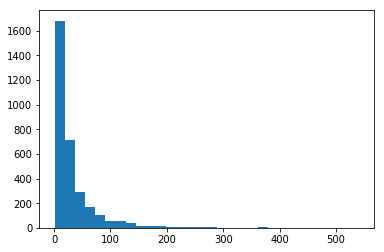

mean degree: 32.3406386976
max degree: 568
min degree: 1


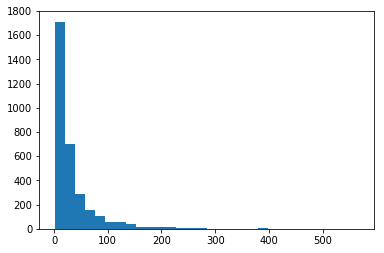

In [132]:
subgraph_1 = S[cc_1]
subgraph_nn = S[cc_nn]

# avg_deg_1 = np.mean(subgraph_1.degree())
# avg_deg_nn = np.mean(subgraph_nn.degree())
# print("mean degree for cc_1: "+ str(avg_deg_1))
# print("mean degree for cc_nn: "+ str(avg_deg_nn))
plot_degree_dist(subgraph_1)
plot_degree_dist(subgraph_nn)

As we can see, these connected components are very similar, not just in their cardinality. They both have similar degree distributions (though admittedly they are both similar to the overall distribution over the network). Their mean degrees are both slightly higher than average, while their max degree is lower than the max over the whole graph. We might conclude that these are both "typical" nodes in similar connected components that are more strongly connected than average. 